# Temperaturas Ciudades

In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from datetime import datetime
from math import *
from util import *
from dateutil.relativedelta import relativedelta # $ pip install python-dateutil

plt.rcParams["figure.figsize"] = (16, 10)

In [36]:
#ciudades = df.query('city == "Akron" | city == "Cincinnati"')
#ciudad = df.query('city == "Lincoln"')

#dfjoinCiudades = df.query('city == "Cincinnati"').join(df.query('city == "Akron"').set_index("ordinal"), on='ordinal', lsuffix='_cin', rsuffix='_akr_')
#ciudad = df.query('city == "Lincoln"')
#df[df["date"] > datetime(1999,1,1)].pivot("city", "avg")

In [126]:
#Se predice por año, NO MES, se hace un avg del año

def dataFrameEnFecha(df, year, qtty):
    """ Devuelve un dataframe desde year hasta year+qtty
    """
    df = df[df['year'] >= year]
    return df[df['year'] < year+qtty]


def pasoComunGenDF(df, calAvg):
    listCities = list(set(df['city']))
    listCitiesQuery = list(set(df['city']))
    for i in range(len(listCitiesQuery)):
        listCitiesQuery[i] = '"' + listCitiesQuery[i] + '"'

    dicCities = {}
    for i in range(len(listCities)):
        #Genero un nuevo dataframe, calculo el avg anual y elimino las filas duplicadas del año y columna 'avg'
        dfCity = pd.DataFrame(df.query('city == ' + listCitiesQuery[i]))

        if(calAvg):
            listAvgYr = list(dfCity.groupby('year').apply(lambda x: x.sum()/12)['avg'])
            dfCity.drop_duplicates(subset='year', inplace=True)
            del dfCity['avg']
            dfCity['avg'] = listAvgYr

        #Agrego el dataframe a un dic
        dicCities[listCities[i]] = dfCity
    
    return dicCities

def genDFAvgYr(df):
    """ Devuelve un dataframe que tiene solo promedio anual
    """
    dicCities = pasoComunGenDF(df, True)
    valDf = list(dicCities.values())
    return pd.concat(valDf)


def generarDFXS(df, varList):
    """ Genero un dataframe con los xs para pasarle a la funcion
    """
    dicCities = pasoComunGenDF(df, False)

    #Genero el dataframe para retornar
    yearCol = list(set(df['year']))
    dfXs = pd.DataFrame()
    for k,v in dicCities.items():
        for c in varList:
            dfXs[c+ " " + k] = list(v[c])
    dfXs['year'] = yearCol
    
    return dfXs


def getListXS(df):
    temp=[]
    for row in df.iterrows():
        index, data = row
        temp.append(data.tolist())
    return [data for index, data in df.iterrows()]

In [128]:
#LEVANTO DATOS
dfWest = pd.read_csv('data/CitiesWestChunk.csv', parse_dates = [0])
dfEast = pd.read_csv('data/CitiesEastChunk.csv', parse_dates = [0])
dfWest.sort_values(['date','country','city'], inplace = True)
dfEast.sort_values(['date','country','city'], inplace = True)

#ME QUEDO CON LOS DATOS DE FECHAS COMUNES EN TODAS
#Datos de 1849 a 2013
minWest = dfWest.groupby("city", as_index=False)["date"].aggregate(["min","max"])["min"].aggregate("max")
maxWest = dfWest.groupby("city", as_index=False)["date"].aggregate(["min","max"])["max"].aggregate("min")
minEast = dfEast.groupby("city", as_index=False)["date"].aggregate(["min","max"])["min"].aggregate("max")
maxEast = dfEast.groupby("city", as_index=False)["date"].aggregate(["min","max"])["max"].aggregate("min")
#print("West (min,max): ", (startWest, endWest))
#print("East (min,max): ", (startEast, endEast))
minTotal = max(minWest, minEast)
maxTotal = min(maxWest, maxWest)
#print("minTotal: ", minTotal)
#print("maxTotal: ", maxTotal)
dfWest = dfWest[dfWest['date'] >= minTotal]
dfWest = dfWest[dfWest['date'] < maxTotal]
dfEast = dfEast[dfEast['date'] >= minTotal]
dfEast = dfEast[dfEast['date'] < maxTotal]

#dfWest['ordinal']= dfWest['date'].apply(lambda x: x.toordinal())
dfWest["year"] = dfWest["date"].apply(lambda d: d.year)
#dfEast['ordinal']= dfEast['date'].apply(lambda x: x.toordinal())
dfEast["year"] = dfEast["date"].apply(lambda d: d.year)

#print(dfWest.head())

#Genero promedio anual y quito promedio mensual
dfWest = genDFAvgYr(dfWest)
dfEast = genDFAvgYr(dfEast)

groupByCitiesW = dfWest.groupby('city')
groupByCitiesE = dfEast.groupby('city')

In [79]:
#funcion lineal cabeza, probar otras
#me hago un df para un ordinal tener todas las temperaturas de todas las ciudades (altitud tambien?)

In [178]:
#Para cada w in CitiesW, calcular(w, CitiesE)
#Para cada e in CitiesE, calcular(e, CitiesW)
listCitiesWest = list(set(dfWest['city']))
listCitiesEast = list(set(dfEast['city']))
listXs = ['avg', 'altitude']
dfW = generarDFXS(dfWest, listXs)
dfE = generarDFXS(dfEast, listXs)

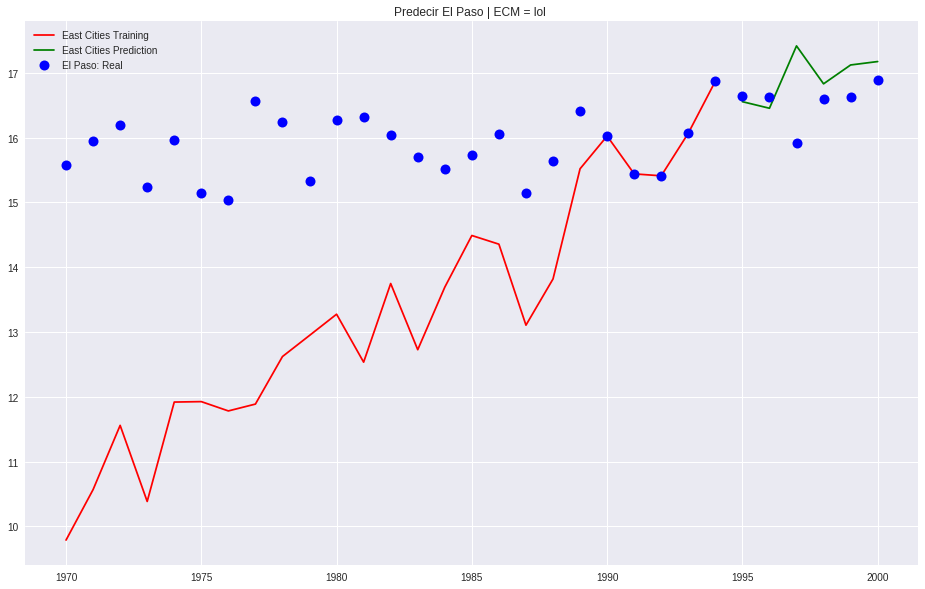

In [179]:
#TEST tomo listCitiesWest[0] e intento predecirlo contra todo listCitiesEast

#TRAINING
dfCityT = groupByCitiesW.get_group(listCitiesWest[0])
dfeT = dfE.copy(deep=True)
#me quedo con los df de la fecha que necesito
dfCityT = dataFrameEnFecha(dfCityT, 1970, 25)
dfeT = dataFrameEnFecha(dfeT, 1970, 25)
fechasT = list(dfeT['year'])

#Con esto genero una lista con los x para pasarle a cml
xsT = dfeT.values.tolist()
ysT = list(dfCityT['avg'])
funcion = lambda xs: [xs[i] for i in range(len(xs))] + [1]

funCML = cml(funcion, xs, ys)
resXST = [funCML(x) for x in xsT]

#PREDICTION
dfCityP = groupByCitiesW.get_group(listCitiesWest[0])
dfeP = dfE.copy(deep=True)
#me quedo con los df de la fecha que necesito
dfCityP = dataFrameEnFecha(dfCityP, 1995, 6)
dfeP = dataFrameEnFecha(dfeP, 1995, 6)
fechasP = list(dfeP['year'])

xsP = dfeP.values.tolist()
ysP = list(dfCityP['avg'])
resXSP = [funCML(x) for x in xsP]


plt.plot(fechasT, resXST, 'r', label='East Cities Training', color='red')
plt.plot(fechasP, resXSP, 'r', label='East Cities Prediction', color='green')

plt.plot(fechasT+fechasP, ysT+ysP, 'o', label=listCitiesWest[0]+': Real', markersize=10, color='blue')

plt.title('{} | ECM = {} '.format("Predecir "+ listCitiesWest[0], 'lol') )
plt.legend()
plt.show()